<h1 style="font-size:3rem;color:#A3623B;">Lab 6</h1>

## Security and Ethical aspects of data
### Amaya Nogales Gómez

## 6.1 Fairness metrics for synthetic datasets


In [140]:
#we import all the required libraries
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # for generating synthetic data 
from sklearn import datasets #For real datasets
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)
import pandas as pd

In [141]:
from sklearn.svm import SVC
from sklearn import metrics

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [142]:
def generate_synthetic_data_bias():

    """
        Code for generating the synthetic data.
        We will have two features and a binary class.
        
    """

    n_samples = 20 # generate these many data points per class
    #For biased data
    p_sen=0.2 #this parameter sets the probability of being protected (sensitive feature=1)
    delta1=[3,-2] # This is the increment of the mean for the positive class
    delta2=[3,-2] # This is the increment of the mean for the negative class
    
    
    def gen_gaussian_sensitive(size, mean_in, cov_in, class_label, sensitive):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(size)
        y = np.ones(size, dtype=int) * class_label
        x_sen = np.ones(size, dtype=float) * sensitive
        return nv,X,y,x_sen

    """ Generate the features randomly """
    #For the NON-protected group (sensitive feature=0, for ex. men)
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    nv1, X1, y1, x_sen1= gen_gaussian_sensitive(int((1-p_sen)*n_samples), mu1, sigma1, 1,0) # positive class
    nv2, X2, y2, x_sen2= gen_gaussian_sensitive(int((1-p_sen)*n_samples),mu2, sigma2, 0,0) # negative class
    
    
    #For the Protected group (sensitive feature=1, for ex. women)
    # We will generate one gaussian cluster for each class
    mu3, sigma3 = np.add(mu1,delta1), [[5, 1], [1, 5]]
    mu4, sigma4 = np.add(mu2,delta2), [[10, 1], [1, 3]]
    nv3, X3, y3, x_sen3 = gen_gaussian_sensitive(int(p_sen*n_samples), mu3, sigma3, 1,1.) # positive class
    nv4, X4, y4, x_sen4 = gen_gaussian_sensitive(int(p_sen*n_samples),mu4, sigma4, 0,1.) # negative class
    

    

    # join the positive and negative class clusters
    X = np.vstack((X1, X2, X3, X4))
    y = np.hstack((y1, y2, y3, y4))
    x_prot= np.hstack((x_sen1, x_sen2, x_sen3, x_sen4))
    

    # shuffle the data
    perm = list(range(0,n_samples*2))
    shuffle(perm)
    X = X[perm]
    y = y[perm]
    x_prot=x_prot[perm]
    
    

    return X,y,x_prot

In [143]:
X_syn, y_syn, x_bias = generate_synthetic_data_bias()

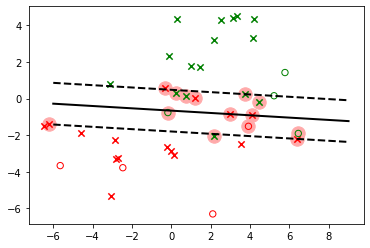

In [144]:
#plt.scatter(X_syn[y_syn==1][:, 0], X_syn[y_syn==1][:, 1], color='#378661', marker='x', s=40, linewidth=1.5, label= "Class +1")
#plt.scatter(X_syn[y_syn==0][:, 0], X_syn[y_syn==0][:, 1], color='#A73730', marker='x', s=40, linewidth=1.5, label = "Class -1")

X_s_0 = X_syn[x_bias == 0.0]
X_s_1 = X_syn[x_bias == 1.0]
y_s_0 = y_syn[x_bias == 0.0]
y_s_1 = y_syn[x_bias == 1.0]

# SVM Classifier model
#the hyperparameter C control the margin violations
#smaller C leads to more margin violations but wider margin

svm_clf = SVC(kernel="linear", C=float(4))
svm_clf.fit(X_syn, y_syn)

plot_svc_decision_boundary(svm_clf, -6, 9)
plt.scatter(X_s_0[y_s_0==1][:, 0], X_s_0[y_s_0==1][:, 1], color='green', marker='x', s=40, linewidth=1.5, label= "Non-prot. +1")
plt.scatter(X_s_0[y_s_0==0][:, 0], X_s_0[y_s_0==0][:, 1], color='red', marker='x', s=40, linewidth=1.5, label = "Non-prot. -1")
plt.scatter(X_s_1[y_s_1==1][:, 0], X_s_1[y_s_1==1][:, 1], color='green', marker='o', facecolors='none', s=40, label = "Prot. +1")
plt.scatter(X_s_1[y_s_1==0][:, 0], X_s_1[y_s_1==0][:, 1], color='red', marker='o', facecolors='none', s=40, label = "Prot. -1")

#plt.savefig('aggre.png')
plt.show()

First we calculate the accuracy of the SVM classifier in our dataset:

In [145]:
#Accuracy
y_pred=svm_clf.predict(X_syn)

print("Accuracy: %.1f" % (metrics.accuracy_score(y_syn, y_pred)*100), "%")


Accuracy: 82.5 %


We first implement the equal opportunity metric:

In [146]:
#Let us now implement the equal opportunity metric:
def equal_opportunity(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size

    for i in range(0,n):
        if (y[i]==1 and x_prot[i]==0):
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (y[i]==1 and x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1
    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_EOpp=abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
    
    return UNF_EOpp


In [147]:
UNF_EOpp=equal_opportunity(y_syn,y_pred, x_bias)
print('UNF_EOpp = %.2f' % (UNF_EOpp*100),"%")

UNF_EOpp = 43.75 %


### Questions:


**1-** Calculate the predictive equality metric for the given dataset and classifier.

**2-** Calculate the equalized odds metric for the given dataset and classifier.

**3-** Calculate the predictive parity metric for the given dataset and classifier.

**4-** Calculate the statistical parity metric for the given dataset and classifier.

**5-** a)Calculate the disparate impact metric for the given dataset and classifier.

  b)Does this classifier satisfy the 80%-rule?
  


<font color="brown">
    1- Calculate the predictive equality metric for the given dataset and classifier.
</font>

In [148]:
#1
def predictive_equality(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size
    for i in range(0,n):
        if (y[i]==0 and x_prot[i]==0):
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (y[i]==0 and x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1    

    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_pe=abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
    
    return UNF_pe




In [149]:
UNF_pe=predictive_equality(y_syn,y_pred, x_bias)
print('UNF_pe = %.2f' % (UNF_pe*100),"%")

UNF_pe = 25.00 %


<font color="brown">
    2- Calculate the equalized odds metric for the given dataset and classifier.
</font>

In [150]:

def equal_odds(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size

    for i in range(0,n):
        if (y[i]==1 and x_prot[i]==0):
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (y[i]==1 and x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1

    UNF_EOpp=abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
 
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size
    for i in range(0,n):
        if (y[i]==0 and x_prot[i]==0):
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (y[i]==0 and x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1
    
    UNF_EOpe=abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))



    return UNF_EOpp + UNF_EOpe


In [151]:
UNF_EOdds=equal_odds(y_syn,y_pred, x_bias)
print('UNF_EOdds = %.2f' % (UNF_EOdds*100),"%")

UNF_EOdds = 68.75 %


<font color= "brown">
    3- Calculate the predictive parity metric for the given dataset and classifier.
<font/>  

In [152]:

def predictive_parity(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size
    for i in range(0,n):
        if (y_pred[i]==1 and x_prot[i]==0):
            Pos_nonpro=Pos_nonpro+1
            if (y[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (y_pred[i]==1 and x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y[i]==1):
                PPos_pro=PPos_pro+1    

    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_pp=abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
    
    return UNF_pp





In [153]:
UNF_pp=predictive_parity(y_syn,y_pred, x_bias)
print('UNF_pp = %.2f' % (UNF_pp*100),"%")

UNF_pp = 21.05 %


<font color="brown">
    4- Calculate the statistical parity metric for the given dataset and classifier.
<font>

In [154]:
#4
def statistical_parity(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size
    for i in range(0,n):
        if (x_prot[i]==0):
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1    

    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    UNF_sp=abs((PPos_nonpro/Pos_nonpro)-(PPos_pro/Pos_pro))
    
    return UNF_sp




In [155]:
UNF_sp=statistical_parity(y_syn,y_pred, x_bias)
print('UNF_sp = %.2f' % (UNF_sp*100),"%")

UNF_sp = 34.38 %


<font color="brown">
    5- a)Calculate the disparate impact metric for the given dataset and classifier.<br>
    b) Does this classifier satisfy the 80%-rule?
</font>

In [156]:
def disparate_impact(y,y_pred, x_prot):
    Pos_pro=0.0
    Pos_nonpro=0.0
    PPos_pro=0.0
    PPos_nonpro=0.0
    
    n=y_pred.size
    for i in range(0,n):
        if (x_prot[i]==0):
            Pos_nonpro=Pos_nonpro+1
            if (y_pred[i]==1):
                PPos_nonpro=PPos_nonpro+1
        if (x_prot[i]==1):
            Pos_pro=Pos_pro+1
            if (y_pred[i]==1):
                PPos_pro=PPos_pro+1    

    #print(Pos_nonpro)
    #print(Pos_pro)
    #print(PPos_pro)
    #print(PPos_nonpro)
    A = (PPos_nonpro/Pos_nonpro)/(PPos_pro/Pos_pro)
    B = (PPos_pro/Pos_pro)/(PPos_nonpro/Pos_nonpro)
    
    return(min(A,B))

In [157]:
UNF_si=disparate_impact(y_syn,y_pred, x_bias)
print('UNF_si = %.2f' % (UNF_si*100),"%")

UNF_si = 42.11 %


As disparate impact is 42.1%, it doesn't satisfy the 80% rule.


## 6.2 Fairness metrics for the German dataset

In [158]:
German_data=np.loadtxt('German.txt')
i_prot=40 #the protected features corresponds with column 40 from the txt file
n_sample=500 # we define our training sample size
C_param=5

X_German=np.delete(German_data,[0,i_prot],1) #We eliminate the first column that correspond to labels and the protected feature

y_German=German_data[:,0] #labels
x_bias_german=German_data[:,i_prot] #protected feature

#Now let us consider a training set
X_G=X_German[1:n_sample,:]
y_G=y_German[1:n_sample]
x_bias_G=x_bias_german[1:n_sample]


# SVM Classifier model
#the hyperparameter C control the margin violations
#smaller C leads to more margin violations but wider margin

svm_clf = SVC(kernel="linear", C=float(C_param))
svm_clf.fit(X_G, y_G)

y_pred_G=svm_clf.predict(X_G)




### Questions:
In the code before, we set i_prot=40, which means we consider the protected feature being "female divorced/separated/married". Under this choice:

**6-** Provide a table with the accuracy and the 6 fairness metrics.

**7-** Does this classifier satisfy the 80%-rule?

Now choose as protected feature being "male divorced/separated", i.e., i_prot=39. Under this choice:

**8-** Provide a table with the 6 fairness metrics.

**9-** Does this classifier satisfy the 80%-rule?

**10-** Which conclusion do you obtain comparing the tables from 6 and 8?

<font color="brown">
    6- Provide a table with the accuracy and the 6 fairness metrics.
</font>



In [159]:
print("Accuracy: %.1f" % (metrics.accuracy_score(y_G, y_pred_G)*100), "%")

UNF_EOpp_G=equal_opportunity(y_G,y_pred_G, x_bias_G)
print('UNF_EOpp = %.2f' % (UNF_EOpp_G*100),"%")

UNF_EOpe_G=predictive_equality(y_G,y_pred_G, x_bias_G)
print('UNF_EOpe = %.2f' % (UNF_EOpe_G*100),"%")

UNF_EOdds_G = abs(UNF_EOpp_G) + abs(UNF_EOpe_G)
print('UNF_EOdds = %.2f' % (UNF_EOdds_G*100),"%")


UNF_pp_G=predictive_parity(y_G,y_pred_G, x_bias_G)
print('UNF_pp = %.2f' % (UNF_pp_G*100),"%")

UNF_sp_G=statistical_parity(y_G,y_pred_G, x_bias_G)
print('UNF_sp = %.2f' % (UNF_sp_G*100),"%")


UNF_DI_G=disparate_impact(y_G,y_pred_G, x_bias_G)
print('UNF_DI = %.2f' % (UNF_DI_G*100),"%")

Accuracy: 81.4 %
UNF_EOpp = 4.25 %
UNF_EOpe = 20.63 %
UNF_EOdds = 24.88 %
UNF_pp = 3.34 %
UNF_sp = 11.85 %
UNF_DI = 85.21 %


<font color="brown">
    7 - Does this classifier satisfy the 80%-rule?
    
</font>

Yes, as disparate impact is 85.21%


<font color="brown">
  Now choose as protected feature being "male divorced/separated", i.e., i_prot=39. Under this choice:

  8 - Provide a table with the 6 fairness metrics.
    
</font>

In [160]:
German_data=np.loadtxt('German.txt')
i_prot=39 #the protected features corresponds with column 40 from the txt file
n_sample=500 # we define our training sample size
C_param=5

X_German=np.delete(German_data,[0,i_prot],1) #We eliminate the first column that correspond to labels and the protected feature

y_German=German_data[:,0] #labels
x_bias_german=German_data[:,i_prot] #protected feature

#Now let us consider a training set
X_G2=X_German[1:n_sample,:]
y_G2=y_German[1:n_sample]
x_bias_G2=x_bias_german[1:n_sample]


# SVM Classifier model
#the hyperparameter C control the margin violations
#smaller C leads to more margin violations but wider margin

svm_clf = SVC(kernel="linear", C=float(C_param))
svm_clf.fit(X_G2, y_G2)

y_pred_G2=svm_clf.predict(X_G2)

In [161]:
print("Accuracy: %.1f" % (metrics.accuracy_score(y_G2, y_pred_G2)*100), "%")

UNF_EOpp_G2=equal_opportunity(y_G2,y_pred_G2, x_bias_G2)
print('UNF_EOpp = %.2f' % (UNF_EOpp_G2*100),"%")

UNF_EOpe_G2=predictive_equality(y_G2,y_pred_G2, x_bias_G2)
print('UNF_EOpe = %.2f' % (UNF_EOpe_G2*100),"%")

UNF_EOdds_G2 = abs(UNF_EOpp_G2) + abs(UNF_EOpe_G2)
print('UNF_EOdds = %.2f' % (UNF_EOdds_G2*100),"%")


UNF_pp_G2=predictive_parity(y_G2,y_pred_G2, x_bias_G2)
print('UNF_pp = %.2f' % (UNF_pp_G2*100),"%")

UNF_sp_G2=statistical_parity(y_G2,y_pred_G2, x_bias_G2)
print('UNF_sp = %.2f' % (UNF_sp_G2*100),"%")


UNF_DI_G2=disparate_impact(y_G2,y_pred_G2, x_bias_G2)
print('UNF_DI = %.2f' % (UNF_DI_G2*100),"%")

Accuracy: 81.2 %
UNF_EOpp = 2.13 %
UNF_EOpe = 13.37 %
UNF_EOdds = 15.50 %
UNF_pp = 11.72 %
UNF_sp = 0.73 %
UNF_DI = 99.04 %


<font color="brown">
  Now choose as protected feature being "male divorced/separated", i.e., i_prot=39. Under this choice:

  9- Does this classifier satisfy the 80%-rule?
    
</font>

Yes, as disparate impact is 99.04%

<font color = 'brown'>

10- Which conclusion do you obtain comparing the tables from 6 and 8?
    
</font>

Setting variable 39 as the protected class increases disparate impact and doesnt affect accuracy at all. So this setting might be better



<h2> 6.3 The COMPAS dataset. What happens if we change the choice of variables?</h2> 

Let's take our own decisions:

In [162]:
# filter dplyr warnings
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [163]:
%%R
library(dplyr)
#You can choose your favorite option:
#a)Download the dataset and access it locally
#raw_data <- read.csv("./compas-scores-two-years.csv") 
#b)Access the dataset directly from the repository
raw_data <- read.csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")
nrow(raw_data)
colnames(raw_data)

 [1] "id"                      "name"                   
 [3] "first"                   "last"                   
 [5] "compas_screening_date"   "sex"                    
 [7] "dob"                     "age"                    
 [9] "age_cat"                 "race"                   
[11] "juv_fel_count"           "decile_score"           
[13] "juv_misd_count"          "juv_other_count"        
[15] "priors_count"            "days_b_screening_arrest"
[17] "c_jail_in"               "c_jail_out"             
[19] "c_case_number"           "c_offense_date"         
[21] "c_arrest_date"           "c_days_from_compas"     
[23] "c_charge_degree"         "c_charge_desc"          
[25] "is_recid"                "r_case_number"          
[27] "r_charge_degree"         "r_days_from_arrest"     
[29] "r_offense_date"          "r_charge_desc"          
[31] "r_jail_in"               "r_jail_out"             
[33] "violent_recid"           "is_violent_recid"       
[35] "vr_case_number"          

Note: if you obtain the following error: "UsageError: Cell magic `%%R` not found."
Try this solution: pip install rpy2


## Filtering of data

<em>In a 2009 study examining the predictive power of its COMPAS score, Northpointe defined recidivism as “a finger-printable arrest involving a charge and a filing for any uniform crime reporting (UCR) code.” We interpreted that to mean a criminal offense that resulted in a jail booking and took place after the crime for which the person was COMPAS scored.

It was not always clear, however, which criminal case was associated with an individual’s COMPAS score. To match COMPAS scores with accompanying cases, we considered cases with arrest dates or charge dates within 30 days of a COMPAS assessment being conducted. In some instances, we could not find any corresponding charges to COMPAS scores. We removed those cases from our analysis.

Next, we sought to determine if a person had been charged with a new crime subsequent to crime for which they were COMPAS screened. We did not count traffic tickets and some municipal ordinance violations as recidivism. We did not count as recidivists people who were arrested for failing to appear at their court hearings, or people who were later charged with a crime that occurred prior to their COMPAS screening.</em>

We do the same filtering that in the Propublica Study **BUT** we select different variables.

Finally we save the filtered csv file.



In [164]:
%%R
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count, 
                    days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out,
                    juv_fel_count,juv_misd_count,juv_other_count,is_violent_recid) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(is_violent_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A')
write.csv(df,"propublica_ext.csv")

nrow(df)

[1] 6172


Now we import the same libraries as in the previous labs.

In [165]:
#we import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # for generating synthetic data 
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

We first read the filtered data. 

In [166]:
df = pd.read_csv("propublica_ext.csv")

print("Size of the dataset: %d" % len(df.index)) #We calculate the number of objects in the dataset




Size of the dataset: 6172


In [167]:
for col in df:
    print(df[col].unique())

[   1    2    3 ... 6170 6171 6172]
[69 34 24 44 41 43 39 27 23 37 47 31 25 64 21 32 26 33 30 55 49 29 51 35
 28 53 38 22 62 56 45 40 50 20 36 54 19 42 52 59 61 63 48 46 58 78 57 66
 70 60 65 68 71 83 67 75 72 74 96 73 80 77 76 79 18]
['F' 'M']
['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']
['Greater than 45' '25 - 45' 'Less than 25']
['Low' 'Medium' 'High']
['Male' 'Female']
[ 0  4 14  3  1  7  6  5 13  8  9 21  2 15 10 28 19 11 23 25 36 12 20 33
 16 18 17 22 30 24 27 26 37 29 31 38]
[ -1   0 -20  22  -2 -24 -13 -15 -10 -30  -4 -16 -26  -7  29  -3  23 -11
 -22 -21 -12  -8  -5 -23 -14  -9  -6 -27 -19 -18  26 -29  28   7 -17 -28
   9 -25  13  20  17  30   6   2  16   8   1  18  15  21  27  11   3  14
   5  24]
[ 1  3  4  6 10  5  9  2  7  8]
[0 1]
[0 1]
['2013-08-13 06:03:42' '2013-01-26 03:45:27' '2013-04-13 04:58:34' ...
 '2014-01-13 05:48:01' '2014-03-08 08:06:02' '2014-06-28 12:16:41']
['2013-08-14 05:41:20' '2013-02-05 05:36:53' '2013-04-14 07:02:04'

We need to binarize all the categorical features we considered in the dataset:

In [168]:
df = (
    pd.read_csv("propublica_ext.csv")
    #We first binarize the categorical feature c_charge_degree
    .assign(c_charge=lambda x:x['c_charge_degree'].replace({'F': 1, 'M':0}))
    #race
    .assign(african_american=lambda x:x['race'].replace({'Other': 0, 'African-American': 1, 'Caucasian': 0, 'Hispanic': 0, 'Asian': 0,'Native American': 0}))
    .assign(caucasian=lambda x:x['race'].replace({'Other': 0, 'African-American': 0, 'Caucasian': 1, 'Hispanic': 0, 'Asian': 0,'Native American': 0}))
    .assign(native_american=lambda x:x['race'].replace({'Other': 0, 'African-American': 0, 'Caucasian': 0, 'Hispanic': 0, 'Asian': 0,'Native American': 1}))
    .assign(hispanic=lambda x:x['race'].replace({'Other': 0, 'African-American': 0, 'Caucasian': 0, 'Hispanic': 1, 'Asian': 0,'Native American': 0}))
    .assign(asian=lambda x:x['race'].replace({'Other': 0, 'African-American': 0, 'Caucasian': 0, 'Hispanic': 0, 'Asian': 1,'Native American': 0}))
    .assign(other=lambda x:x['race'].replace({'Other': 1, 'African-American': 0, 'Caucasian': 0, 'Hispanic': 0, 'Asian': 0,'Native American': 0}))
    #age_cat
    .assign(less_than_25=lambda x:x['age_cat'].replace({'Greater than 45':0, '25 - 45':0, 'Less than 25':1}))
    .assign(between_25_45=lambda x:x['age_cat'].replace({'Greater than 45':0, '25 - 45':1, 'Less than 25':0}))
    .assign(greater_than_25=lambda x:x['age_cat'].replace({'Greater than 45':1, '25 - 45':0, 'Less than 25':0}))
    #score_text
    .assign(score_low=lambda x:x['score_text'].replace({'Low':1, 'Medium':0, 'High':0}))
    .assign(score_medium=lambda x:x['score_text'].replace({'Low':0, 'Medium':1, 'High':0}))
    .assign(score_high=lambda x:x['score_text'].replace({'Low':0, 'Medium':0, 'High':1}))
    #sex
    .assign(Male=lambda x:x['sex'].replace({'Male': 1, 'Female':0}))
    
)
DeleteList=['c_charge_degree','race','age_cat','score_text','sex','c_jail_in','c_jail_out']
df=df.drop(DeleteList, axis=1)
print("Dataset with %d" % df.shape[0],"objects and %d" % df.shape[1], "variables") #We calculate the number of objects in the dataset

df.head()


Dataset with 6172 objects and 25 variables


,Unnamed: 0,age,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,juv_fel_count,juv_misd_count,juv_other_count,...,hispanic,asian,other,less_than_25,between_25_45,greater_than_25,score_low,score_medium,score_high,Male
0,1,69,0,-1,1,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
1,2,34,0,-1,3,1,1,0,0,0,...,0,0,0,0,1,0,1,0,0,1
2,3,24,4,-1,4,1,1,0,0,1,...,0,0,0,1,0,0,1,0,0,1
3,4,44,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1
4,5,41,14,-1,6,1,1,0,0,0,...,0,0,0,0,1,0,0,1,0,1


Actually, our dataset is only composed of 23 variables, since we do not include the first column as variable, and the variable "two_year_recid" is the binary label to predict.

We then define our data and our label:


In [169]:
display(df.columns)

Index(['Unnamed: 0', 'age', 'priors_count', 'days_b_screening_arrest',
       'decile_score', 'is_recid', 'two_year_recid', 'juv_fel_count',
       'juv_misd_count', 'juv_other_count', 'is_violent_recid', 'c_charge',
       'african_american', 'caucasian', 'native_american', 'hispanic', 'asian',
       'other', 'less_than_25', 'between_25_45', 'greater_than_25',
       'score_low', 'score_medium', 'score_high', 'Male'],
      dtype='object')

We now select from this list only the variables we want to consider in our classification problem and the corresponding labels:

In [177]:
# Here is a way to select these columns using the column names
    
#feature_columns = ['Number_of_Priors', 'score_factor','Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American','Asian', 'Hispanic', 'Native_American', 'Other', 'Female',       'Misdemeanor']

feature_columns = ['age', 'priors_count', 'days_b_screening_arrest',
         'juv_fel_count',
       'juv_misd_count', 'juv_other_count', 'is_violent_recid', 'c_charge',
        'less_than_25', 'between_25_45', 'greater_than_25',
        'Male']


data = df[feature_columns].values
y = df['two_year_recid'].values
df=df.assign(COMPAS_Decision=lambda x:x['score_low'].replace({0: 1, 1:0}))
y_compas = df['COMPAS_Decision'].values

In [178]:
#We load the libraries for the SVM

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# shuffle the data
#n_samples=data.shape[0]
#perm = list(range(0,n_samples))
#shuffle(perm)
#data = data[perm]
#y = y[perm]
#y_compas=y_compas[perm]


#Create train and validation set
#train_x, test_x, train_y, test_y = train_test_split(data, y, test_size=0.1, shuffle=True, stratify=y, random_state=42)

svm_clf = SVC(kernel="linear", C=1.0)
svm_clf.fit(data, y)

y_pred=svm_clf.predict(data)


#svm_clf = SVC(kernel="linear", C=1.0)
#svm_clf.fit(train_x, train_y)

#ytrain_pred=svm_clf.predict(train_x)
#ytest_pred=svm_clf.predict(test_x)



In [179]:
b_recid = df[df['african_american'] == 1]
w_recid = df[df['caucasian'] == 1]
print(
    ' Accuracy SVM (All):  \t %.2f' % (metrics.accuracy_score(y, y_pred)*100), "%\n",
    'Accuracy SVM (Black):\t %.2f' % (metrics.accuracy_score(y_pred[df['african_american'] == 1], b_recid['two_year_recid'])*100),"%\n", 
    'Accuracy SVM (White):\t %.2f' % (metrics.accuracy_score(y_pred[df['caucasian'] == 1], w_recid['two_year_recid'])*100),"%\n",

)

pd.crosstab(y_pred, df['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')

FPR_s=pd.crosstab(y_pred, df['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[0][1]
FNR_s=pd.crosstab(y_pred, df['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[1][0].astype('float')

print("FPR SVM %.2f" % (FPR_s*100),"%")
print("FNR SVM %.2f" % (FNR_s*100),"%")




 Accuracy SVM (All):  	 70.01 %
 Accuracy SVM (Black):	 68.57 %
 Accuracy SVM (White):	 71.18 %

FPR SVM 9.60 %
FNR SVM 54.40 %


## Questions:

**11-** Provide the accuracy for the COMPAS dataset.

**12-** Provide the accuracy for black defendants for the COMPAS dataset.

**13-** Provide the accuracy for white defendants for the COMPAS dataset.

**14-** Provide the FPR for the COMPAS dataset.

**15-** Provide the FNR for the COMPAS dataset.



<font color = 'brown'>

11 - Provide the accuracy for the COMPAS dataset.
    
</font>

In [180]:
print('Accuracy of COMPAS DATASET: ',round(metrics.accuracy_score(y_true = df['two_year_recid'],y_pred = df['COMPAS_Decision']),4),'\n')

Accuracy of COMPAS DATASET:  0.6607 



<font color = 'brown'>

12- Provide the accuracy for black defendants for the COMPAS dataset.
    
</font>

In [181]:
print('Accuracy of Black: ',round(metrics.accuracy_score(y_true = b_recid['two_year_recid'],y_pred = b_recid['COMPAS_Decision']),4),'\n')

Accuracy of Black:  0.6491 



<font color = 'brown'>

13- Provide the accuracy for white defendants for the COMPAS dataset.
    
</font>

In [182]:
print('Accuracy of White: ',round(metrics.accuracy_score(y_true = w_recid['two_year_recid'],y_pred = w_recid['COMPAS_Decision']),4),'\n')

Accuracy of White:  0.6719 



<font color = 'brown'>

14- Provide the FPR for the COMPAS dataset.
    
</font>

In [183]:
FPR=pd.crosstab(df['COMPAS_Decision'], df['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[0][1]
print("FPR is %.2f" % (FPR*100),"%")

FPR is 30.27 %


<font color = 'brown'>

15- Provide the FNR for the COMPAS dataset.
    
</font>

In [184]:
FNR=pd.crosstab(df['COMPAS_Decision'], df['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[1][0].astype('float')
print("FNR is %.2f" % (FNR*100),"%")

FNR is 38.31 %


In [185]:
#For the COMPAS:
FPR_b=pd.crosstab(b_recid['COMPAS_Decision'], b_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[0][1]

FNR_b=pd.crosstab(b_recid['COMPAS_Decision'], b_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[1][0].astype('float')

print("FPR of Black %.2f" % (FPR_b*100),"%")
print("FNR of Black %.2f" % (FNR_b*100),"%")



FPR of Black 42.34 %
FNR of Black 28.48 %


## Questions:

For the COMPAS classifier:

**16-** Calculate the FPR for white defendants.

**17-** Calculate the FNR for white defendants.

**18-** Replace **x** by the right number in the two following statement:

"FPR of Black is **x** times greater than for White"

**19-** Replace **x** by the right number in the two following statement:

"FNR of Black is **x** times smaller than for White"



<font color = 'brown'>

16 - Calculate the FPR for white defendants.
    
</font>

In [186]:
FPR_w=pd.crosstab(w_recid['COMPAS_Decision'], w_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[0][1]
print("FPR of white %.2f" % (FPR_w*100),"%")



FPR of white 22.01 %


<font color = 'brown'>

17 - Calculate the FPR for white defendants.
    
</font>

In [187]:
FNR_w=pd.crosstab(w_recid['COMPAS_Decision'], w_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[1][0].astype('float')
print("FNR of white %.2f" % (FNR_w*100),"%")



FNR of white 49.64 %


<font color = 'brown'>

18- Replace x by the right number in the two following statement:

"FPR of Black is x times greater than for White"
    
</font>

In [188]:
print("FPR of Black %.2f" % ((FPR_b/FPR_w)),'times greater than for white')

FPR of Black 1.92 times greater than for white


<font color = 'brown'>

19 - Replace x by the right number in the two following statement:

"FNR of Black is x times smaller than for White"
    
</font>

In [189]:
print("FNR of Black %.2f" % ((FNR_w/FNR_b)),'times smaller than for white')

FNR of Black 1.74 times smaller than for white


In [190]:
#For the SVM:
FPR_b=pd.crosstab(y_pred[df['african_american'] == 1], b_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[0][1]
FNR_b=pd.crosstab(y_pred[df['african_american'] == 1], b_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[1][0].astype('float')

print("FPR of Black %.2f" % (FPR_b*100),"%")
print("FNR of Black %.2f" % (FNR_b*100),"%")

FPR of Black 13.74 %
FNR of Black 47.56 %


## Questions:

For the SVM classifier:

**20-** Calculate the FPR for white defendants.

**21-** Calculate the FNR for white defendants.

**22-** Replace **x** by the right number in the two following statement:

"FPR of Black is **x** times greater than for White"

**23-** Replace **x** by the right number in the two following statement:

"FNR of Black is **x** times smaller than for White"

<font color = 'brown'>

20 - Calculate the FPR for white defendants.
    
</font>

In [191]:
FPR_w=pd.crosstab(y_pred[df['caucasian'] == 1], w_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[0][1]

print("FPR of white %.2f" % (FPR_w*100),"%")

FPR of white 6.48 %


<font color = 'brown'>

21 - Calculate the FNR for white defendants.

    
</font>

In [192]:
FNR_w=pd.crosstab(y_pred[df['caucasian'] == 1], w_recid['two_year_recid'], rownames=['Predicted recividism'],colnames=['Actual recividism'],normalize='columns')[1][0].astype('float')

print("FNR of white %.2f" % (FNR_w*100),"%")


FNR of white 63.63 %


<font color = 'brown'>

22 - Replace x by the right number in the two following statement:

"FPR of Black is x times greater than for White"
    
</font>

In [193]:
print("FPR of Black %.2f" % ((FPR_b/FPR_w)),'times greater than for white')

FPR of Black 2.12 times greater than for white


<font color = 'brown'>

23 - Replace x by the right number in the two following statement:

"FNR of Black is x times smaller than for White"
    
</font>

In [194]:
print("FNR of Black %.2f" % ((FNR_w/FNR_b)),'times smaller than for white')

FNR of Black 1.34 times smaller than for white


## Questions: 

**24-** Fill in the following table:

**25-** Which is the best solution in terms of accuracy? Is it fair (in terms of accuracy)?

**26-** Which is the best solution in terms of FPR? Based on answers 18 and 22, which solution is more fair (in terms of FPR)?

**27-** Which is the best solution in terms of FNR? Based on answers 19 and 23, which solution is more fair (in terms of FNR)?

**28-** Calculate the 6 fairness metrics for the COMPAS classifier.

**29-** Calculate the 6 fairness metrics for the SVM classifier.

**30-** As a future (or actual) data scientist, which solution would you choose for **this** specific problem? Justify your answer.

<font color = 'brown'>

24 - Fill in the following table:

    
</font>

$$
\begin{array}{cc}
& \text{SVM }&\text{COMPAS }\\
&\begin{array}{cccc}
\hline \hline 
&\text { All } & \text { Black } & \text { White }\\
\hline 
\text{Accuracy}& 70.01 & 68.57  &  71.18 \\
\text{FPR}& 9.60 & 13.74 & 6.48 \\
\text{FNR}& 54.40 & 47.56  & 63.63 \\
\hline
\end{array}
&\begin{array}{cccc}
\hline \hline 
&\text { All } & \text { Black } & \text { White }\\
\hline 
\text{Accuracy}& 66.07& 64.91 & 67.19  \\
\text{FPR}& 30.27 & 42.34 & 22.01 \\
\text{FNR}& 38.31 & 28.48 & 49.64 \\
\hline
\end{array}\\
\end{array}
$$

<font color = 'brown'>

25 - Which is the best solution in terms of accuracy? Is it fair (in terms of accuracy)?
    
</font>

The best solution in terms of accuracy is the SVM. However, in terms of fairness for each class in accuracy the difference is almost the same for both (~3)

<font color = 'brown'>

26 - Which is the best solution in terms of FPR? Based on answers 18 and 22, which solution is more fair (in terms of FPR)?

    
</font>

The SVM has less FPR overall, but the COMPAS is more fair in terms of FPR

<font color = 'brown'>

27- Which is the best solution in terms of FNR? Based on answers 19 and 23, which solution is more fair (in terms of FNR)?
    
</font>

The compas has less FNR overall, but the SVM is more fair in terms of the classes, as FNR is just 1.34 smaller for black than for white

<font color = 'brown'>

28- Calculate the 6 fairness metrics for the COMPAS classifier.
    
</font>

In [196]:
UNF_EOpp_C=equal_opportunity(df['two_year_recid'],df['COMPAS_Decision'],df['african_american'])
print('UNF_EOpp = %.2f' % (UNF_EOpp_C*100),"%")

UNF_EOpe_C=predictive_equality(df['two_year_recid'],df['COMPAS_Decision'],df['african_american'])
print('UNF_EOpe = %.2f' % (UNF_EOpe_C*100),"%")

UNF_EOdds_C = equal_odds(df['two_year_recid'],df['COMPAS_Decision'],df['african_american'])
print('UNF_EOdds = %.2f' % (UNF_EOdds_C*100),"%")


UNF_pp_C=predictive_parity(df['two_year_recid'],df['COMPAS_Decision'],df['african_american'])
print('UNF_pp = %.2f' % (UNF_pp_C*100),"%")

UNF_sp_C=statistical_parity(df['two_year_recid'],df['COMPAS_Decision'],df['african_american'])
print('UNF_sp = %.2f' % (UNF_sp_C*100),"%")


UNF_DI_C=disparate_impact(df['two_year_recid'],df['COMPAS_Decision'],df['african_american'])
print('UNF_DI = %.2f' % (UNF_DI_C*100),"%")

UNF_EOpp = 24.05 %
UNF_EOpe = 21.95 %
UNF_EOdds = 46.00 %
UNF_pp = 5.84 %
UNF_sp = 26.84 %
UNF_DI = 53.40 %


<font color = 'brown'>

29- Calculate the 6 fairness metrics for the SVM classifier.
    
</font>

In [197]:
UNF_EOpp_SVM=equal_opportunity(y,y_pred,df['african_american'])
print('UNF_EOpp = %.2f' % (UNF_EOpp_SVM*100),"%")

UNF_EOpe_SVM=predictive_equality(y,y_pred,df['african_american'])
print('UNF_EOpe = %.2f' % (UNF_EOpe_SVM*100),"%")

UNF_EOdds_SVM = equal_odds(y,y_pred,df['african_american'])
print('UNF_EOdds = %.2f' % (UNF_EOdds_SVM*100),"%")


UNF_pp_SVM=predictive_parity(y,y_pred,df['african_american'])
print('UNF_pp = %.2f' % (UNF_pp_SVM*100),"%")

UNF_sp_SVM=statistical_parity(y,y_pred,df['african_american'])
print('UNF_sp = %.2f' % (UNF_sp_SVM*100),"%")


UNF_DI_SVM=disparate_impact(y,y_pred,df['african_american'])
print('UNF_DI = %.2f' % (UNF_DI_SVM*100),"%")

UNF_EOpp = 16.72 %
UNF_EOpe = 7.52 %
UNF_EOdds = 24.24 %
UNF_pp = 2.63 %
UNF_sp = 16.47 %
UNF_DI = 51.55 %


<font color = 'brown'>

30- As a future (or actual) data scientist, which solution would you choose for this specific problem? Justify your answer.
    
</font>